In [1]:
print("hello world")

hello world


Training a CNN for multi-class multi-labeling classification (MCMLC) on 512*512*3 retinal images over the 3 mains labels beeing DR, MH, ODC according to the EDA. 

In [2]:
import os
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)


from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics
from classes.RetinaDataset import RetinaDataset
from classes.CNNMultiClassMultiLabeling import CNNMultiClassMultiLabeling

# 1. Data Transformation

In [ ]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((512, 512)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## 2. Data Loading


In [4]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"]
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"]
)


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)


## 3. Model init

In [7]:
# Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNMultiClassMultiLabeling(number_of_classes=3).to(device)

## 4. Fonction de perte et métriques

In [8]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 5. Entrainement du modèle

### A. Paramétrage

In [9]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_val_loss = float('inf')
counter = 0

# Stockage des métriques
training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 2  

### B. Entrainement

In [10]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        dataset=train_dataset,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1-score: {train_f1:.4f} | Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | Test F1-score: {test_f1:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Mémoire GPU utilisée: {torch.cuda.memory_allocated() / 1024**3:.2f} Go")

    # Early stopping
    if epoch > 5:
        if (best_train_loss - train_loss) > min_delta:
            best_train_loss = train_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)
    torch.cuda.empty_cache()
    print("="*70)

Epoch number: 0


100%|██████████| 56/56 [00:05<00:00, 10.38it/s]


Train Loss: 0.6966 | Train Accuracy: 0.5474 | Train F1-score: 0.0460 | Train ROC-AUC: 0.5034
Test Loss: 243.9937 | Test Accuracy: 0.5365 | Test F1-score: 0.0000 | Test ROC-AUC: 0.5000
Mémoire GPU utilisée: 2.02 Go
Epoch number: 1


100%|██████████| 56/56 [00:04<00:00, 11.74it/s]


Train Loss: 0.6931 | Train Accuracy: 0.5564 | Train F1-score: 0.0000 | Train ROC-AUC: 0.4999
Test Loss: 317.1706 | Test Accuracy: 0.5365 | Test F1-score: 0.0000 | Test ROC-AUC: 0.5000
Mémoire GPU utilisée: 2.02 Go


In [11]:
torch.save(model.state_dict(), '../Models/model_simple_cnn_mcmlc_retina.pth')

In [13]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_simple_cnn_mcmlc_retina.csv', index=False)

## 6. Evolution of the training

In [3]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_simple_cnn_mcmlc_retina.csv')

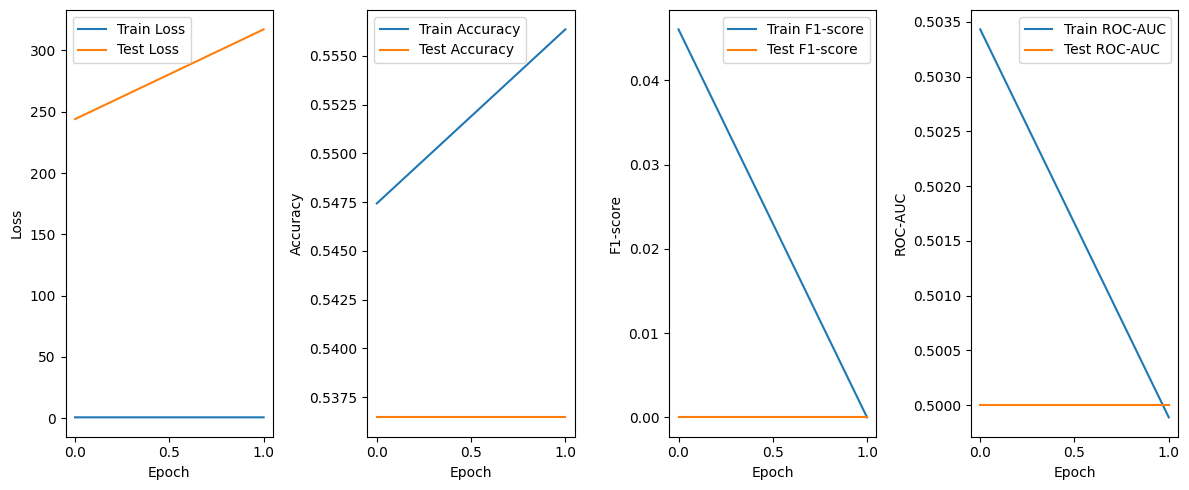

In [4]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_mcmlc_retina_zoomed.png',
    title='Training Evolution - Simple CNN Multi-Class Multi-Labeling',
    zoomed=True
)

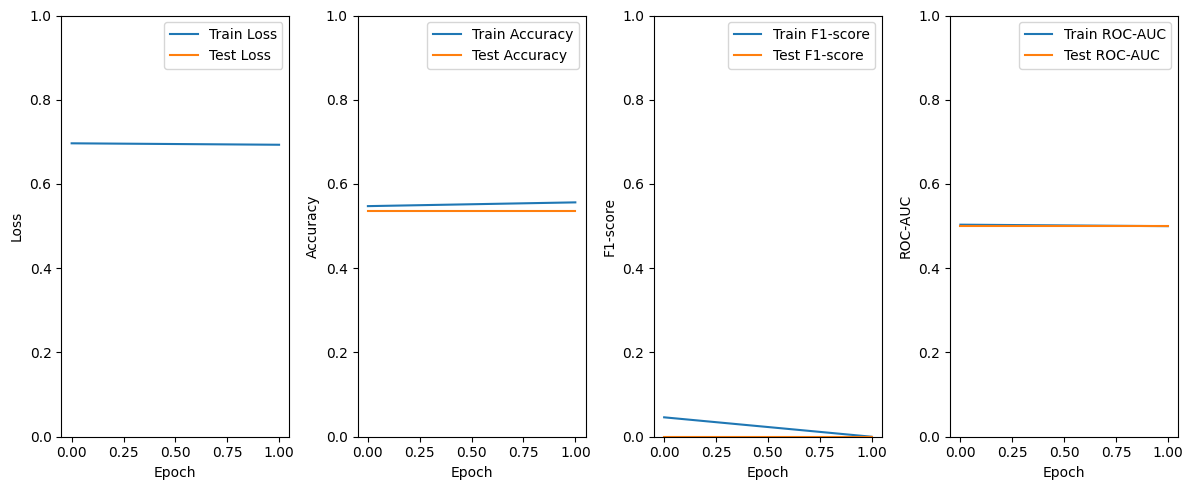

In [5]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_simple_cnn_mcmlc_retina.png',
    title='Training Evolution - Simple CNN Multi-Class Multi-Labeling',
    zoomed=False
)

## 7. Model evaluation

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNMultiClassMultiLabeling(number_of_classes=3).to(device)
model.load_state_dict(torch.load('../Models/model_simple_cnn_mcmlc_retina.pth', weights_only=True))
criterion = nn.BCEWithLogitsLoss() 

In [25]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device)

In [26]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 265.6540 | Validation Accuracy: 0.5828 | Validation F1-score: 0.0000 | Validation ROC-AUC: 0.5000


Results are very bad..